In [91]:
#This code implements the binning algorithm that can be used to estimate pmfs from raw data
#We first give the general code, which estimates any f(Z|Y), and then provide a tool to facilitate its use when estimating plant pmfs
#We only give the minimal interface and a few simple examples, please refer to the ReadMe file for more explainations on how to use the code

#Code author: Émiland Garrabé

In [92]:
import numpy as np

In [93]:
def discretize(Z, Zdim, Zmin, Zstep):
    ###
    #Discretize a variable Z using its dimension Zdim, its minimal values along each axis and the discretization steps
    res = [0]*Zdim #n-dimensional index
    for i in range(Zdim): #For each dimension
        elt = Z[i] #Extract the i-th element
        ind = int((elt - Zmin[i])//Zstep[i]) #Discretize
        res[i] = ind
    return(tuple(res)) #Return as tuple for array indexing

In [94]:
def getJointPMFs(data, Zdim, Zmin, Zstep, Zdiscr, Ydim, Ymin, Ystep, Ydiscr):
    ###
    #Get the joint PMFs for Y and Z,Y using all the info on the variables (dim, mins, steps)
    fullDiscr = Ydiscr + Zdiscr #List of the discretization steps (along each dimension) for both Z and Y
    fullJoint = np.zeros(fullDiscr) #f(Z,Y)
    Yjoint = np.zeros(Ydiscr) #f(Y)
    for history in data: #For each trajectory in the dataset
        Zhist = history[0] #Extract the histories for Z and Y
        Yhist = history[1]
        for i in range(len(Zhist)): #For each data point in the trajectory
            Z = Zhist[i] #Extract the realization of Z and Y
            Y = Yhist[i]
            Zind = discretize(Z, Zdim, Zmin, Zstep) #Find the indexes
            Yind = discretize(Y, Ydim, Ymin, Ystep)
            fullInd = Yind + Zind #Get the index of the joint variable Z,Y
            fullJoint[fullInd] = fullJoint[fullInd] + 1 #Update the values
            Yjoint[Yind] = Yjoint[Yind] + 1
    fullJoint = fullJoint/np.sum(fullJoint) #Normalizing
    Yjoint = Yjoint/np.sum(Yjoint)
    return(fullJoint, Yjoint)

In [95]:
def getConditionnal(fullJoint, Yjoint, Zdiscr, Ydiscr, Zdim):
    ###
    #Get f(Z|Y) using the joint pmfs
    fullDiscr = Ydiscr + Zdiscr
    conditionnal = np.zeros(fullDiscr) #Initialize the pmf
    for (index, x) in np.ndenumerate(fullJoint): #For each index and each value in f(Z,Y) (we use this as it's robust w.r.t. the dimension)
        Yind = index[:Ydim] #Extract the index for Y
        if Yjoint[Yind] == 0: #Protect from dividing by zero
            conditionnal[index] = 0
        else:
            conditionnal[index] = fullJoint[index]/Yjoint[Yind] #Division
    return(conditionnal)

In [96]:
def formatHistory(sysData):
    ###
    #Translate a history in (x,u) form to (Z,Y) form (this means formatting Y_{k-1}:=(x_{k-1},u_k))
    data = [] #Initialize resulting data
    for hist in sysData: #For each (x,u) trajectory
        x = hist[0] #States
        u = hist[1] #Inputs
        L = len(x)-1 #Amount of data points (one less than the full length of the history)
        newZ = [0]*L #Z
        newY = [0]*L #Y
        for i in range(L): #For each point
            #The following lines are a safety: if we have 1D states or inputs, adding them will not concatenate the list but create a false value
            if isinstance(x[i+1], int) or isinstance(x[i+1],float):
                newZ[i] = [x[i+1]] #If x_k is a number, we turn it into a list to fit the binning algorithm's requirements
            else:
                newZ[i] = x[i+1] #Else we use it as is (which simply means leaving it as a list)
            if isinstance(x[i], int) or isinstance(x[i],float): #Same for x_{k-1}
                newY[i] = [x[i]]
            else:
                newY[i] = x[i]
            if isinstance(u[i+1], int) or isinstance(u[i+1],float): #Same for u_k
                newY[i] = newY[i] + [u[i+1]]
            else:
                newY[i] = newY[i] + u[i+1]
        data = data + [[newZ, newY]] #We add the trajectory to the data
    return(np.array(data)) #Returning a numpy array

In [97]:
#We give the following example for a system with the following dynamics:
#x_{k+1} = x_k + u_{k+1} + N(0,1) (normal law)
#Both the state and the input are 1D, which makes the joint variable Y 2D. We use coarse discretizations to make the example quick to execute.

#Dimensions of the variables
Zdim = 1
Ydim = 2

#Minimum values (as lists)
Zmin = [0]
Ymin = [0,0]

#Discretization steps (as lists)
Zstep = [1]
Ystep = [1,1]

#Amount of discrete bins (as lists)
Zdiscr = [10]
Ydiscr = [10,2]

#We will only generate a trajectory, with 100000 elements.
#Notice how the elements are simply added as ints/floats to showcase how formatHistory handles such cases by adding turning the data points into lists.
x = [0]*100000 #Initiates state and input trajectory
u = [0]*100000
for i in range(99999): #There is a useless point as the nature of a dynamic system implies we have one less input than state.
    uk = np.random.randint(2) #Pick a random action
    xm1 = x[i] #Look up the previous state
    xk = np.random.normal(uk + xm1,1) #New state following the noisy dynamics
    if xk>9: #Safety to prevent indexes that are out of the discretization bounds.
        xk = 9
    if xk<0:
        xk=0
    x[i+1] = xk#[xk]
    u[i+1] = uk#[uk]
h = [x,u] #A history, or trajectory, is made out of a history for Z and Y.
sysData = [h] #The dataset is a list of all trajectories, in our case only one
dt = formatHistory(sysData) #Give the data a form that the binning code can use

(full, Y) = getJointPMFs(dt, Zdim, Zmin, Zstep, Zdiscr, Ydim, Ymin, Ystep, Ydiscr) #Get the joint pmfs with the parameters
cond = getConditionnal(full, Y, Zdiscr, Ydiscr, Zdim) #Get the conditional pmf

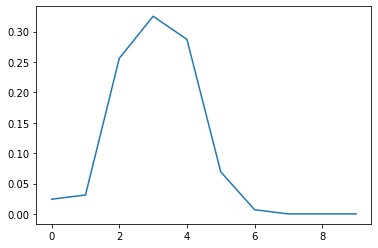

In [98]:
#As an example, we plot some of the conditional pmfs
#cond being a multidimensional array, the indew must be the indexes for the desired x_{k-1} followed by the indexes for the desired u_k
#In the case of a multidimensional state the visualization can become difficult.
#Note how we use the function discretize to automatically generate the index for which we want to visualize the pmf. This can be handy to directly access f(x_k|x_{k-1},u_k)
import matplotlib.pyplot as plt
plt.plot(cond[discretize([3,0], Ydim, Ymin, Ystep)])